In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from joblib import dump, load
np.set_printoptions(suppress=True)
seed = 1
numpy.random.seed(seed)

plt.rcParams['figure.figsize'] = [15, 7]

Using TensorFlow backend.


In [2]:
dataframe = pd.read_csv("datasets/old/test6_real.txt", sep=" ",header=None,names=["x","y","z"])
dataframe.describe()

,x,y,z
count,126.000000,126.000000,126.000000
mean,71.050063,163.374198,870.364627
std,2276.756809,1016.121903,394.305707
min,-3401.257000,-1594.186000,427.060000
25%,-2241.145500,-533.719250,454.039250
50%,45.072500,248.745000,951.748500
75%,2329.906250,1028.066500,981.826750
max,3484.111000,1573.625000,1526.312000


In [3]:
dataframe = pd.read_csv("datasets/old/test6 (1).txt", sep=" ",header=None,names=["x","y","z"])
dataframe.describe()

,x,y,z
count,149.000000,149.000000,149.000000
mean,0.000000,0.000000,493.288591
std,2325.247284,1062.819713,410.942297
min,-3500.000000,-1600.000000,0.000000
25%,-2333.000000,-1066.000000,0.000000
50%,0.000000,0.000000,500.000000
75%,2333.000000,1066.000000,1000.000000
max,3500.000000,1600.000000,1000.000000


In [4]:
Xdfs=[]
Ydfs=[]

Xdfs.append(pd.read_csv("datasets/old/test3 (1).txt", sep=" ",header=None,names=["x","y","z"]))
Xdfs.append(pd.read_csv("datasets/old/test5 (1).txt", sep=" ",header=None,names=["x","y","z"]))

Ydfs.append(pd.read_csv("datasets/old/test3_real.txt", sep=" ",header=None,names=["x","y","z"]))
Ydfs.append(pd.read_csv("datasets/old/test5_real.txt", sep=" ",header=None,names=["x","y","z"]))

Xdfs=pd.concat(Xdfs)
Ydfs=pd.concat(Ydfs)

Xdfs = Xdfs.applymap(lambda x: x/1000)
Ydfs = Ydfs.applymap(lambda x: x/1000)

In [5]:
Xdfs.head()

,x,y,z
0,0.000,0.0,0.0
1,3.500,1.6,0.0
2,2.333,1.6,0.0
3,1.166,1.6,0.0
4,0.000,1.6,0.0


In [6]:
Ydfs.head()

,x,y,z
0,0.000342,-0.000943,0.431775
1,3.427356,1.575200,0.437573
2,2.283631,1.547118,0.429957
3,1.139112,1.536724,0.434870
4,0.003472,1.563510,0.450297


In [7]:
def Unity2R(x,y,z):
    return z,-x,y
        
def R2Unity(x,y,z):
    return -y,z,x

X = pd.DataFrame(columns=['x', 'y', 'z'])
Y = pd.DataFrame(columns=['tx', 'ty', 'tz'])


for index, row in Xdfs.iterrows():
    x,y,z = R2Unity(row["x"],row["y"],row["z"])
    X = X.append({'x': x,'y': y,'z': z }, ignore_index=True)
    
for index, row in Ydfs.iterrows():
    x,y,z = R2Unity(row["x"],row["y"],row["z"])
    Y = Y.append({'tx': x,'ty': y,'tz': z }, ignore_index=True) 
    
    

In [8]:
X.head()

,x,y,z
0,-0.0,0.0,0.000
1,-1.6,0.0,3.500
2,-1.6,0.0,2.333
3,-1.6,0.0,1.166
4,-1.6,0.0,0.000


In [9]:
Y.head()

,tx,ty,tz
0,0.000943,0.431775,0.000342
1,-1.575200,0.437573,3.427356
2,-1.547118,0.429957,2.283631
3,-1.536724,0.434870,1.139112
4,-1.563510,0.450297,0.003472


In [10]:
Y["tx"] = Y["tx"]-X["x"]
Y["ty"] = Y["ty"]-X["y"]
Y["tz"] = Y["tz"]-X["z"]
Y.head()

,tx,ty,tz
0,0.000943,0.431775,0.000342
1,0.024800,0.437573,-0.072644
2,0.052882,0.429957,-0.049369
3,0.063276,0.434870,-0.026888
4,0.036490,0.450297,0.003472


In [11]:
Y.describe()

,tx,ty,tz
count,276.000000,276.000000,276.000000
mean,0.009138,0.451800,-0.010490
std,0.026464,0.030742,0.042022
min,-0.054992,0.386321,-0.091558
25%,-0.009575,0.431605,-0.043150
50%,0.007477,0.451327,0.003902
75%,0.024681,0.470370,0.022344
max,0.076014,0.540783,0.053455


In [12]:
err=mean_squared_error(np.zeros(Y.shape),Y)
print(err)

0.0692384587968019


In [22]:
scaler = StandardScaler()
scaler_sim = load('sim_scaler.joblib') 

#X_scaled = scaler.fit_transform(X)
X_scaled = scaler_sim.transform(X)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.5, random_state=seed)
y_train.describe()

,tx,ty,tz
count,138.000000,138.000000,138.000000
mean,0.008213,0.449676,-0.015175
std,0.027674,0.032252,0.043910
min,-0.054992,0.386321,-0.091558
25%,-0.009908,0.430279,-0.055723
50%,0.004238,0.448910,0.001901
75%,0.022575,0.470723,0.021592
max,0.076014,0.539609,0.050965


In [20]:
def baseline_model(activation='sigmoid'):
    model = Sequential()
    model.add(Dense(8, input_dim=3, kernel_initializer='normal', activation=activation))
    model.add(Dense(3, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
    return model
modelNew = baseline_model(activation='sigmoid')

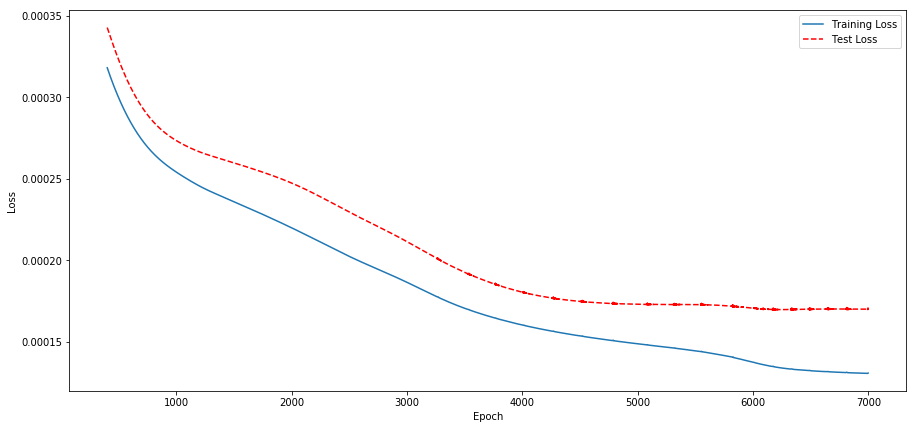

[0.00016997524085570563, 0.00016981889476466142, 0.00017003473647148832, 0.00016978610724597277, 0.00017014901909378913, 0.00016975466567172818, 0.0001703548569310224, 0.00016972659535576762, 0.0001706384813390134]


In [111]:

fromepochs=400
toepochs=7000



def train(ep):
    model.fit(X_train,y_train,epochs=1,batch_size=300, verbose=0)
    pred1=model.predict(X_train)
    pred2=model.predict(X_test)
    err1=mean_squared_error(pred1,y_train)
    err2=mean_squared_error(pred2,y_test)
    return err1,err2
plt_err1=[]
plt_err2=[]
epch=[]
for ep in range(1,toepochs):
    err1,err2=train(ep)
    plt_err1.append(err1)
    plt_err2.append(err2)
    epch.append(ep)
 
plt.plot(epch[fromepochs:toepochs],plt_err1[fromepochs:toepochs],label="Training Loss")
plt.plot(epch[fromepochs:toepochs],plt_err2[fromepochs:toepochs],'r--',label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#linear result 0.00027259772860490494
#best result with scaling 0.0001350731628132509, 0.00013509313236622418, 0.00013503978865384624, 0.00013510244778265837, 0.00013504164606259852, 0.0001350717746163913, 0.00013506672869523397
#best result without scaling 0.00017827291209704626, 0.00017826212229627252, 0.00017826361899764235
#best result with external scaler 0.00016997524085570563
print(plt_err2[-10:-1])

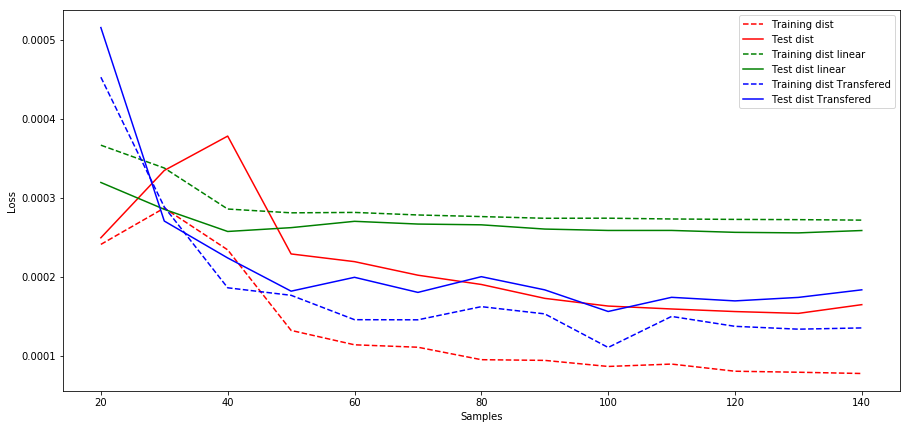

In [27]:
from sklearn.linear_model import LinearRegression

plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]
numsamples=[]


for numsample in range(2, 15):
    print(numsample)
    modelTransferred = keras.models.load_model('sim_model.h5')
    model_linear = LinearRegression()
    
    modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=700 + round(numsample*400),batch_size=numsample, verbose=0)
    pred1=modelNew.predict(X_train)
    pred2=modelNew.predict(X_test)
    err1=mean_squared_error(pred1,y_train)
    err2=mean_squared_error(pred2,y_test)
    
    modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=700 + round(numsample*400),batch_size=numsample, verbose=0)
    pred1=modelTransferred.predict(X_train)
    pred2=modelTransferred.predict(X_test)
    err3=mean_squared_error(pred1,y_train)
    err4=mean_squared_error(pred2,y_test)
    
    model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
    pred1=model_linear.predict(X_train)
    pred2=model_linear.predict(X_test)
    err5=mean_squared_error(pred1,y_train)
    err6=mean_squared_error(pred2,y_test)
    
    plt_err1.append(err1)
    plt_err2.append(err2)
    
    plt_err1_transferred.append(err3)
    plt_err2_transferred.append(err4)
    
    plt_err1_linear.append(err5)
    plt_err2_linear.append(err6)
    
    numsamples.append(numsample*10)
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()


2
3
4
5
6
7
8
9
10
11
12
13
14


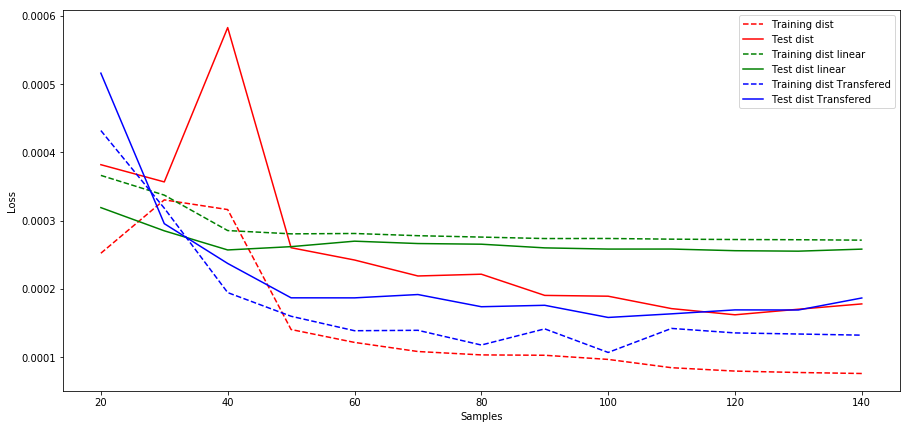

In [28]:
from sklearn.linear_model import LinearRegression

plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]
numsamples=[]


for numsample in range(2, 15):
    print(numsample)
    modelTransferred = keras.models.load_model('sim_model.h5')
    model_linear = LinearRegression()
    
    modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=800 + round(numsample*500),batch_size=numsample, verbose=0)
    pred1=modelNew.predict(X_train)
    pred2=modelNew.predict(X_test)
    err1=mean_squared_error(pred1,y_train)
    err2=mean_squared_error(pred2,y_test)
    
    modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=800 + round(numsample*500),batch_size=numsample, verbose=0)
    pred1=modelTransferred.predict(X_train)
    pred2=modelTransferred.predict(X_test)
    err3=mean_squared_error(pred1,y_train)
    err4=mean_squared_error(pred2,y_test)
    
    model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
    pred1=model_linear.predict(X_train)
    pred2=model_linear.predict(X_test)
    err5=mean_squared_error(pred1,y_train)
    err6=mean_squared_error(pred2,y_test)
    
    plt_err1.append(err1)
    plt_err2.append(err2)
    
    plt_err1_transferred.append(err3)
    plt_err2_transferred.append(err4)
    
    plt_err1_linear.append(err5)
    plt_err2_linear.append(err6)
    
    numsamples.append(numsample*10)
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()


2
3
4
5
6
7
8
9
10
11
12
13
14


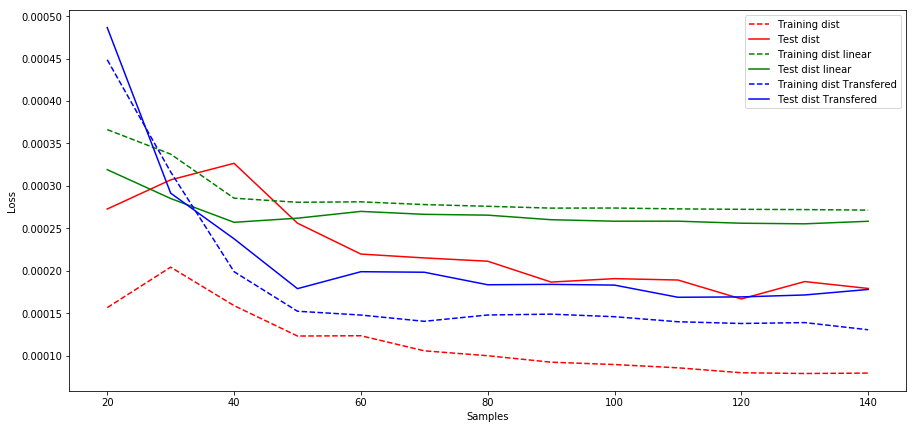

In [29]:
from sklearn.linear_model import LinearRegression

plt_err1=[]
plt_err2=[]
plt_err1_linear=[]
plt_err2_linear=[]
plt_err1_transferred=[]
plt_err2_transferred=[]
numsamples=[]


for numsample in range(2, 15):
    print(numsample)
    modelTransferred = keras.models.load_model('sim_model.h5')
    model_linear = LinearRegression()
    
    modelNew.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=300 + round(numsample*500),batch_size=numsample, verbose=0)
    pred1=modelNew.predict(X_train)
    pred2=modelNew.predict(X_test)
    err1=mean_squared_error(pred1,y_train)
    err2=mean_squared_error(pred2,y_test)
    
    modelTransferred.fit(X_train[0:numsample*10],y_train[0:numsample*10],epochs=300 + round(numsample*500),batch_size=numsample, verbose=0)
    pred1=modelTransferred.predict(X_train)
    pred2=modelTransferred.predict(X_test)
    err3=mean_squared_error(pred1,y_train)
    err4=mean_squared_error(pred2,y_test)
    
    model_linear.fit(X_train[0:numsample*10],y_train[0:numsample*10])
    pred1=model_linear.predict(X_train)
    pred2=model_linear.predict(X_test)
    err5=mean_squared_error(pred1,y_train)
    err6=mean_squared_error(pred2,y_test)
    
    plt_err1.append(err1)
    plt_err2.append(err2)
    
    plt_err1_transferred.append(err3)
    plt_err2_transferred.append(err4)
    
    plt_err1_linear.append(err5)
    plt_err2_linear.append(err6)
    
    numsamples.append(numsample*10)
    
plt.plot(numsamples,plt_err1,'r--',label="Training dist")
plt.plot(numsamples,plt_err2,'r',label="Test dist")

plt.plot(numsamples,plt_err1_linear,'g--',label="Training dist linear")
plt.plot(numsamples,plt_err2_linear,'g',label="Test dist linear")

plt.plot(numsamples,plt_err1_transferred,'b--',label="Training dist Transfered")
plt.plot(numsamples,plt_err2_transferred,'b',label="Test dist Transfered")

plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()
plt.show()
